In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.feature_extraction import settings
from tsfresh.utilities.dataframe_functions import impute
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tqdm.autonotebook import tqdm

In [2]:
def extract_tsfeatures(data, settings):
    long_dfs = pd.DataFrame(
                {
                    0: data.reshape(-1),
                    1: np.arange(data.shape[0]).repeat(data.shape[1])
                }
            )
    long_dfs.shape
    
    s_features = extract_features(
        long_dfs, column_id=1, 
        impute_function=impute, 
        default_fc_parameters=settings,
        n_jobs=6,
        disable_progressbar=True,
        show_warnings=False
    )
    return s_features

def getX(X, settings):
    X = extract_tsfeatures(X, settings)
    print(X.shape)

    scaler = StandardScaler()
    selector = VarianceThreshold(threshold=0)

    X_reduced = selector.fit_transform(X)
    X_scaler = scaler.fit_transform(X_reduced)

    return X_scaler

def plot_df(df, arr, title, one, ans):
    w = 3
    fig = figure(figsize=(5, 4))
    plt.title(title)
    for claster_k in arr:
        if one:
            plt.plot(df[:, ans == claster_k][:, 0], linewidth=w)
        else:
            plt.plot(df[:, ans == claster_k], linewidth=w)
    if one is True:
        plt.legend(arr)
    plt.grid()
    plt.show()

In [3]:
#Чтение train
train_df = pd.read_csv("train.csv").set_index("time")
names_data = train_df.columns
train_data_mean = train_df.rolling(20).mean().dropna()
#Масштабирование
scaler = StandardScaler()
train_data_mean_scale = scaler.fit_transform(train_data_mean)
#Фичи
settings_efficient = settings.EfficientFCParameters()
X_scaler = getX(train_data_mean_scale.transpose(), settings_efficient)
#Уменьшение размерности
svd = TruncatedSVD(n_components=45)    
X_scaler_decomp = svd.fit_transform(X_scaler)
svd.explained_variance_ratio_.sum()

(100, 781)


0.9570945580917753

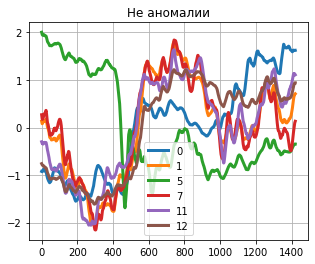

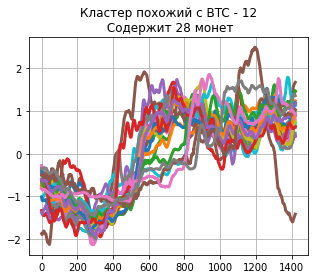

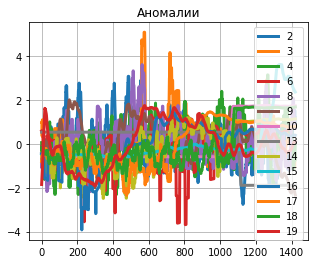

In [4]:
CLUSTER_SIZE = 20

kmeans = KMeans(n_clusters=CLUSTER_SIZE, random_state=0).fit(X_scaler_decomp)
ans = kmeans.labels_

clusters = np.unique(ans)
counts = np.bincount(ans)
no_anomaly_cluster = clusters[counts != 1]
anomaly_cluster = clusters[counts == 1]

plot_df(train_data_mean_scale, no_anomaly_cluster, "Не аномалии", True, ans)

btc_cluster = ans[names_data == "BTC"][0]
btc_title = "Кластер похожий c BTC - {}\n Содержит {} монет".format(btc_cluster, counts[btc_cluster])
plot_df(train_data_mean_scale, ans[names_data == "BTC"], btc_title, False, ans)

plot_df(train_data_mean_scale, anomaly_cluster, "Aномалии", True, ans)

Можно удалить все аномалии и сделать число кластеров намного меньше, но я подумал что посмотреть на все аномалии с помощью K means проще чем удалять все руками

In [5]:
anomaly_names = []
for i in anomaly_cluster:
    anomaly_names.append(names_data[ans == i][0])
anomaly_names

['USDC',
 'USDT',
 'DENT',
 'NEAR',
 'BUSD',
 'COTI',
 'MINA',
 'XEC',
 'ANKR',
 'STPT',
 'IOTX',
 'POLY',
 'QNT',
 'AVAX']

In [6]:
train_df_clean = train_df.drop(anomaly_names, axis=1)
train_df_clean.to_csv("train_clean.csv")

In [7]:
#Чтение train
train_df = pd.read_csv("train_clean.csv").set_index("time")
names_data = train_df.columns
train_data_mean = train_df.rolling(20).mean().dropna()
#Масштабирование
scaler = StandardScaler()
train_data_mean_scale = scaler.fit_transform(train_data_mean)
#Фичи
settings_efficient = settings.EfficientFCParameters()
X_scaler = getX(train_data_mean_scale.transpose(), settings_efficient)
#Уменьшение размерности
svd = TruncatedSVD(n_components=50)    
X_scaler_decomp = svd.fit_transform(X_scaler)
svd.explained_variance_ratio_.sum()

(86, 781)


0.9553047269367386

In [9]:
def show_silhouette(metric):
    distortions = []
    silhouette = []
    K = range(5, 15)
    for k in tqdm(K):
        kmeanModel = TimeSeriesKMeans(n_clusters=k, metric=metric, n_jobs=6, max_iter=10, n_init=5)
        kmeanModel.fit(X_scaler_decomp)
        distortions.append(kmeanModel.inertia_)
        silhouette.append(silhouette_score(X_scaler_decomp, kmeanModel.labels_, metric="euclidean"))


    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(K, distortions, 'b-')
    ax2.plot(K, silhouette, 'r-')

    ax1.set_xlabel('# clusters')
    ax1.set_ylabel('Distortion', color='b')
    ax2.set_ylabel('Silhouette', color='r')

    plt.show()

In [10]:
def show_res(ans):

    clusters = np.unique(ans)
    counts = np.bincount(ans)
    no_anomaly_cluster = clusters[counts != 1]
    anomaly_cluster = clusters[counts == 1]
    plot_df(train_data_mean_scale, no_anomaly_cluster, "Не аномалии", True, ans)

    btc_cluster = ans[names_data == "BTC"][0]
    btc_title = "Кластер похожий c BTC - {}\n Содержит {} монет".format(btc_cluster, counts[btc_cluster])
    plot_df(train_data_mean_scale, ans[names_data == "BTC"], btc_title, False, ans)
    if(len(anomaly_cluster) != 0):
        plot_df(train_data_mean_scale, anomaly_cluster, "Aномалии", True, ans)
    else:
        print("Аномалий нет")
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

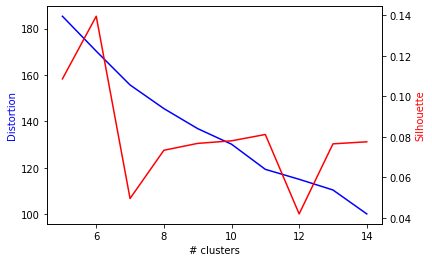

  0%|          | 0/10 [00:00<?, ?it/s]

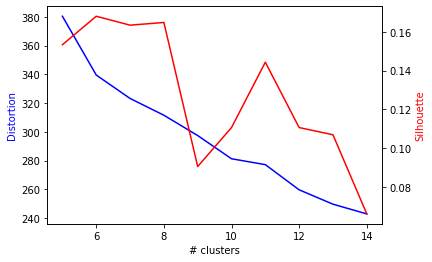

In [11]:
DEBUG = False

if DEBUG:
    show_silhouette("dtw")
    show_silhouette("euclidean")

                                  kmeans sklearn


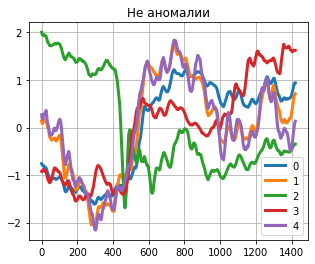

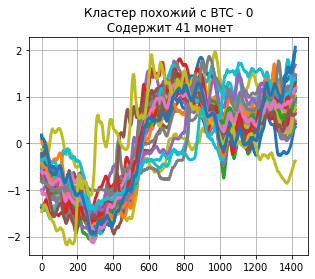

Аномалий нет
                                  tslearn


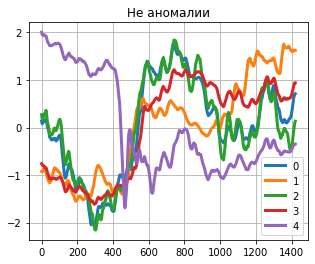

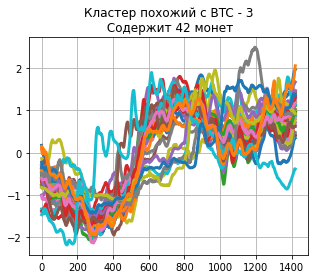

Аномалий нет
                                  dtw


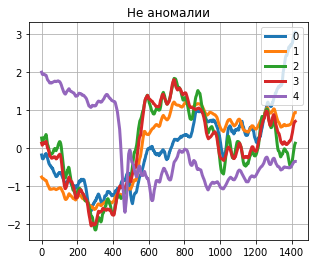

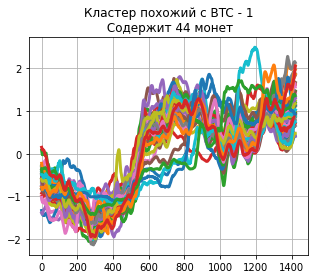

Аномалий нет


In [23]:
model_dtw = TimeSeriesKMeans(n_clusters=5, metric="dtw", n_jobs=6, n_init=5).fit(X_scaler_decomp)

model_kmeans = TimeSeriesKMeans(n_clusters=5, metric="euclidean", n_jobs=6, n_init=5).fit(X_scaler_decomp)

model_kmeans_sklearn = KMeans(n_clusters=5, random_state=0).fit(X_scaler_decomp)

print("                                  kmeans sklearn")
show_res(model_kmeans_sklearn.labels_)
print("                                  tslearn")
show_res(model_kmeans.labels_)
print("                                  dtw")
show_res(model_dtw.labels_)

                                  kmeans sklearn


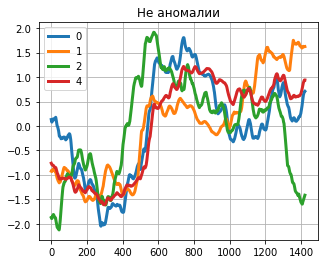

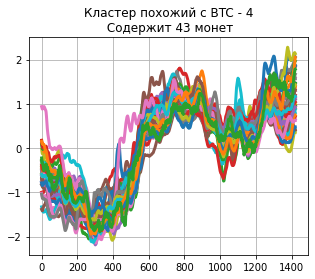

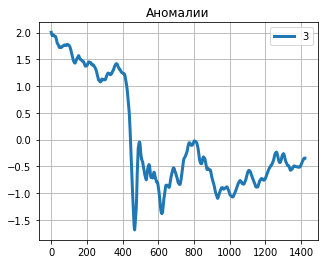

                                  tslearn


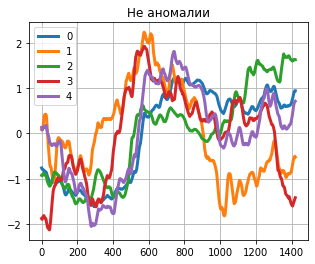

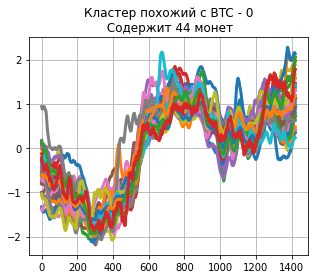

Аномалий нет
                                  dtw


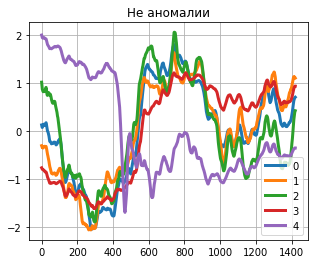

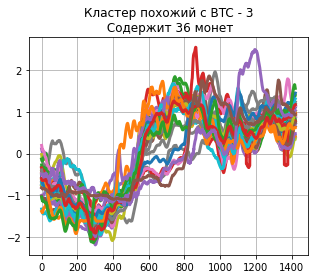

Аномалий нет


In [22]:
#ДОЛГО не запускать
model_dtw = TimeSeriesKMeans(n_clusters=5, metric="dtw", n_jobs=20, max_iter = 10).fit(train_data_mean_scale.T)

model_kmeans = TimeSeriesKMeans(n_clusters=5, metric="euclidean", n_jobs=6, max_iter = 10).fit(train_data_mean_scale.T)

model_kmeans_sklearn = KMeans(n_clusters=5, random_state=0).fit(train_data_mean_scale.T)

print("                                  kmeans sklearn")
show_res(model_kmeans_sklearn.labels_)
print("                                  tslearn")
show_res(model_kmeans.labels_)
print("                                  dtw")
show_res(model_dtw.labels_)